In [4]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [25]:
df = web.DataReader('MSFT',data_source = 'yahoo', start='2012-01-01' , end='2019-12-17')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,26.959999,26.389999,26.549999,26.770000,64731500.0,22.080940
2012-01-04,27.469999,26.780001,26.820000,27.400000,80516100.0,22.600586
2012-01-05,27.730000,27.290001,27.379999,27.680000,56081400.0,22.831539
2012-01-06,28.190001,27.530001,27.530001,28.110001,99455500.0,23.186216
2012-01-09,28.100000,27.719999,28.049999,27.740000,59706800.0,22.881027
...,...,...,...,...,...,...
2019-12-11,151.869995,150.330002,151.539993,151.699997,18856600.0,151.699997
2019-12-12,153.440002,151.020004,151.649994,153.240005,24612100.0,153.240005
2019-12-13,154.889999,152.830002,153.000000,154.529999,23845400.0,154.529999


AttributeError: module 'matplotlib.pyplot' has no attribute 'xlabled'

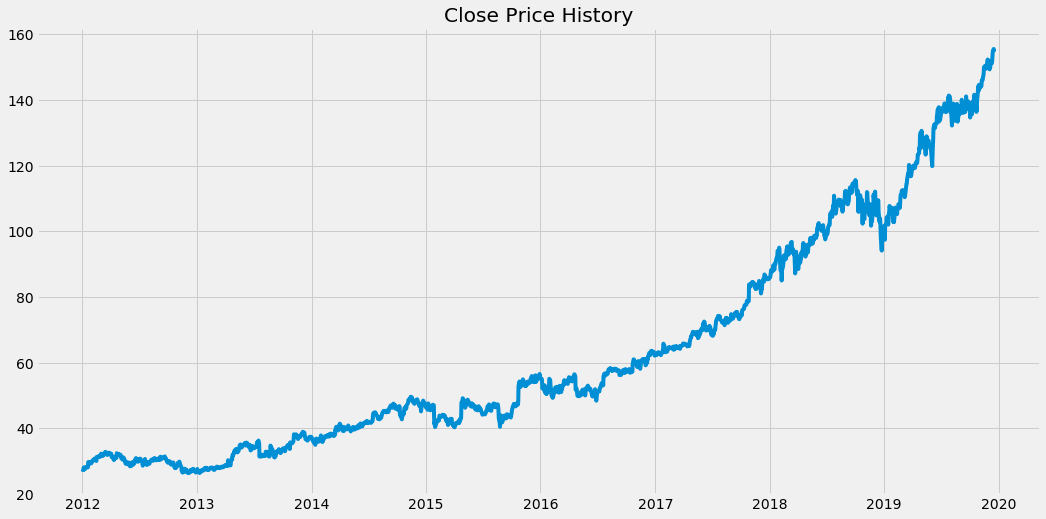

In [22]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabled('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [23]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset)* .8)

training_data_len

1603

In [27]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00309693],
       [0.0079746 ],
       [0.01014245],
       ...,
       [0.99225766],
       [1.        ],
       [0.99349647]])

In [28]:
train_data = scaled_data[0:training_data_len,:]
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [29]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))


In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
1543/1543 [==============================] - 54s 35ms/step - loss: 4.4770e-04


In [31]:
test_data = scaled_data[training_data_len - 60: , : ]
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))


In [32]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [33]:
rmse=np.sqrt(np.mean((predictions- y_test)**2))
rmse

6.996235249090579

c:\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


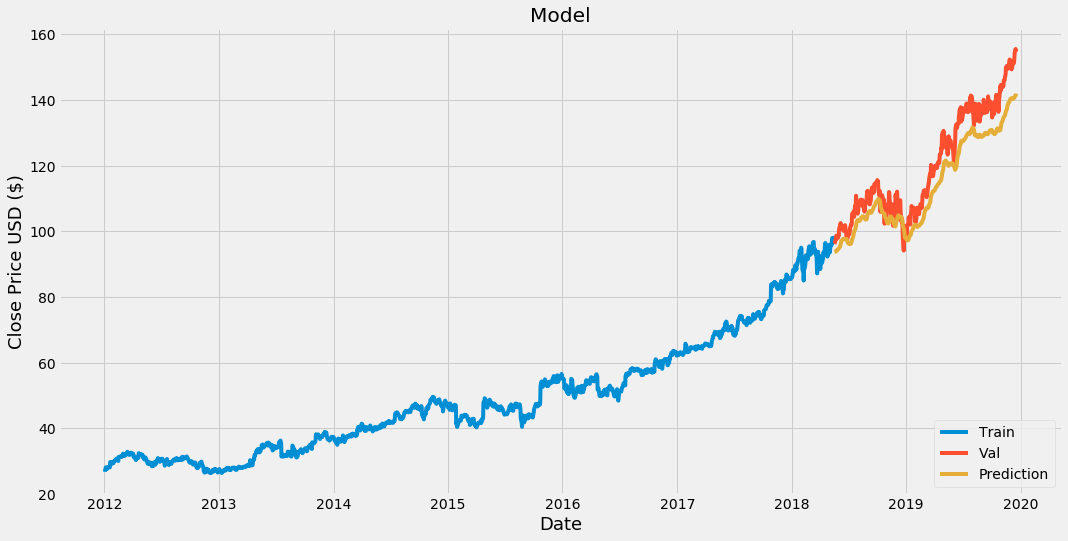

In [35]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Prediction' ], loc='lower right')
plt.show()